# Feature importance

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.inspection import permutation_importance
import pickle
import numpy as np
import pandas as pd
from utils.utils_pixel import *
import matplotlib.pyplot as plt

# MLFlow
import mlflow
import mlflow.sklearn
import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

## Load trained model

In [2]:
with open('RF_clean_update.pkl', 'rb') as f:
    rf = pickle.load(f)

## Load test data

In [3]:
n_timesteps_in = 9
n_timesteps_out = 1
n_feats_in = 85
n_feats_out = 1
exp = 'clean_update'
sample_type = 'pixel_data'
n_batches_te = 100
batch_size = 40

In [7]:
feature_set = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "NDVI", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]
remove_band = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SP", "TCC",
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]

In [12]:
# get the current batch of data
X_all = np.empty([batch_size*n_batches_te, n_timesteps_in, len(feature_set)-len(remove_band)])
y_all = np.empty([batch_size*n_batches_te, n_timesteps_out, 1])

for batch_nbr in range(n_batches_te):
    # Load a batch here 
    img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='test', exp=exp, n_timesteps_out=n_timesteps_out)
    # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

    img = remove_features_batch_level(img, remove_band, feature_set)
    label = remove_features_batch_level(label, remove_band, feature_set)

    # still predict both, but dont use cp_idx for masking clouds in loss
    to_keep = [1]
    label = label[:,:,to_keep,:,:]
    
    X_batch = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
    y_batch = np.empty([batch_size, n_timesteps_out, 1])
    X_batch[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
    y_batch[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()
    
    X_all[batch_nbr*batch_size:(batch_nbr+1)*batch_size, :, :] = X_batch
    y_all[batch_nbr*batch_size:(batch_nbr+1)*batch_size, :, :] = y_batch

In [13]:
# Concatenate all timesteps after each other
X_test = np.reshape(X_all, (batch_size*n_batches_te, n_timesteps_in*(len(feature_set)-len(remove_band))))
y_test = np.reshape(y_all, (batch_size*n_batches_te, n_timesteps_out*n_feats_out))

## Permutation importance on test set

In [21]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = ["CP_t0", "NDVI_t0", "SR_t0", "T_t0", "TP_t0", "DEM_t0",
                "CP_t1", "NDVI_t1", "SR_t1", "T_t1", "TP_t1", "DEM_t1",
                "CP_t2", "NDVI_t2", "SR_t2", "T_t2", "TP_t2", "DEM_t2",
                "CP_t3", "NDVI_t3", "SR_t3", "T_t3", "TP_t3", "DEM_t3",
                "CP_t4", "NDVI_t4", "SR_t4", "T_t4", "TP_t4", "DEM_t4",
                "CP_t5", "NDVI_t5", "SR_t5", "T_t5", "TP_t5", "DEM_t5",
                "CP_t6", "NDVI_t6", "SR_t6", "T_t6", "TP_t6", "DEM_t6",
                "CP_t7", "NDVI_t7", "SR_t7", "T_t7", "TP_t7", "DEM_t7",
                "CP_t8", "NDVI_t8", "SR_t8", "T_t8", "TP_t8", "DEM_t8"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

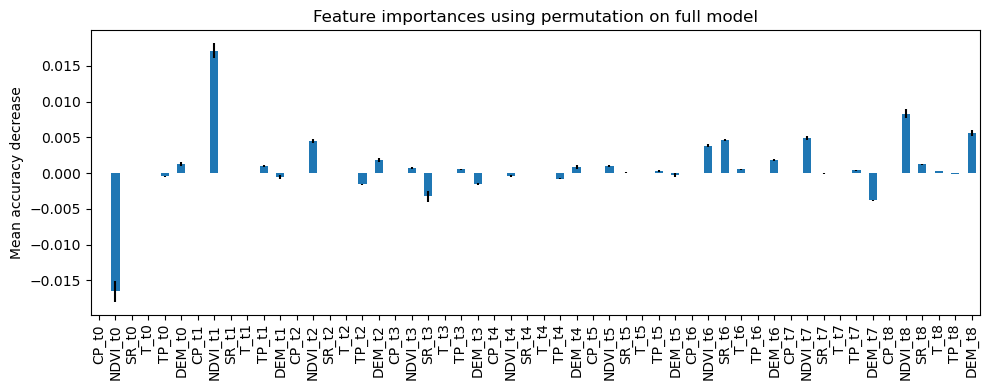

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [37]:
fi = pd.DataFrame(forest_importances).reset_index()
fi["feat"] = fi["index"].apply(lambda x: x.split('_')[0])
fi_feat = fi.groupby('feat').sum()[0]

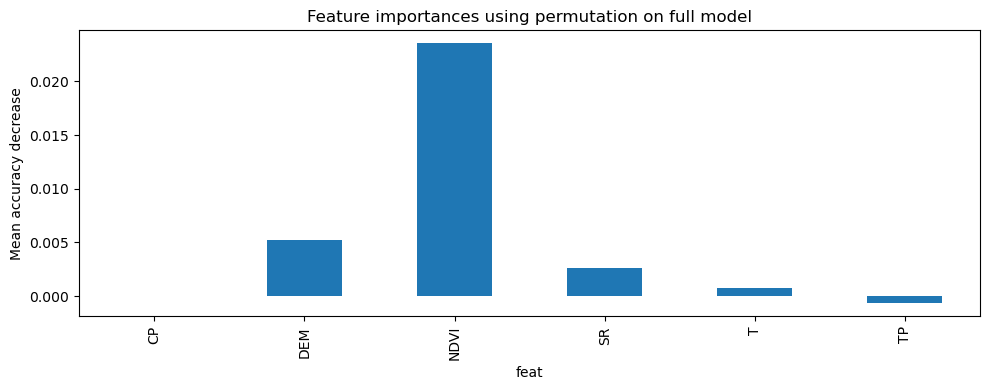

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
fi_feat.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()